In [43]:
#Code to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [44]:
#Download required libraries
!pip install yfinance
!pip install pyts
!pip install einops

### **Required Imports**

In [45]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
import tensorflow as tf
import tensorflow_datasets as tfds
from pyts.image import GramianAngularField
from skimage.transform import resize
from collections import deque
import random
import math
import six
from einops.layers.tensorflow import Rearrange
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets
import logging
from fastprogress import master_bar, progress_bar

### **Data Collection and Preprocessing**

In [46]:
# Code to download the stock data
stock_symbol = 'BAJFINANCE.NS'
stock_data = yf.download(stock_symbol, period="5y")
df = pd.DataFrame(stock_data)
df.reset_index(inplace = True)

print("Size of the data: ",df.shape[0])

[*********************100%%**********************]  1 of 1 completed
Size of the data:  1236


In [47]:
#Compute the mid value for the stock, that would be considered as that day's price
df['Mid'] = (df['Low']+df['High'])/2.0

In [48]:
#Display the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid
0,2018-12-11,2360.000000,2446.500000,2332.100098,2426.750000,2383.787354,2189278,2389.300049
1,2018-12-12,2445.000000,2514.899902,2434.350098,2493.949951,2449.797852,1683197,2474.625000
2,2018-12-13,2510.199951,2528.949951,2475.000000,2489.100098,2445.033447,1713161,2501.974976
3,2018-12-14,2488.250000,2512.000000,2464.250000,2486.350098,2442.332520,1204379,2488.125000
4,2018-12-17,2498.600098,2509.899902,2466.250000,2474.399902,2430.593750,1019602,2488.074951


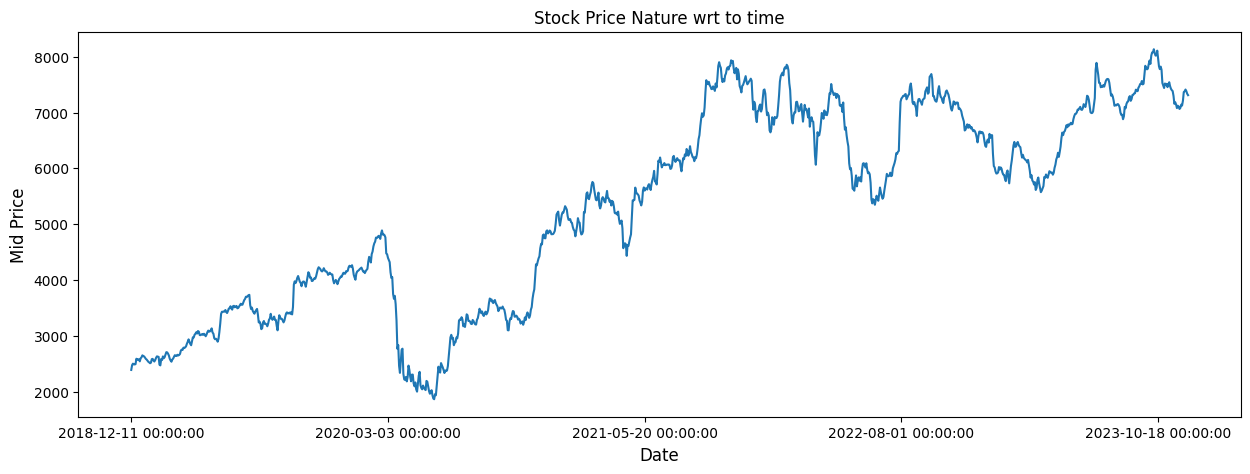

In [49]:
#Visualize the nature of price through out the time period
plt.figure(figsize = (15,5))
plt.plot(range(df.shape[0]),(df['Mid']))
plt.xticks(range(0,df.shape[0],300),df['Date'].loc[::300],rotation=0)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price',fontsize=12)
plt.title("Stock Price Nature wrt to time")
plt.show()

In [50]:
#Define the Parameters
SEQ_LEN = 60  #Window Size
FUTURE_PERIOD_PREDICT = 1
RATIO_TO_PREDICT = "Mid"

In [51]:
#Function to classify whether in future the price will increase or decrease
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [52]:
#Assign the target column accordingly
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [53]:
#Display the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mid,future,target
0,2018-12-11,2360.000000,2446.500000,2332.100098,2426.750000,2383.787354,2189278,2389.300049,2474.625000,1
1,2018-12-12,2445.000000,2514.899902,2434.350098,2493.949951,2449.797852,1683197,2474.625000,2501.974976,1
2,2018-12-13,2510.199951,2528.949951,2475.000000,2489.100098,2445.033447,1713161,2501.974976,2488.125000,0
3,2018-12-14,2488.250000,2512.000000,2464.250000,2486.350098,2442.332520,1204379,2488.125000,2488.074951,0
4,2018-12-17,2498.600098,2509.899902,2466.250000,2474.399902,2430.593750,1019602,2488.074951,2492.400024,1


#### **Splitting Data into Train, Valid and Test Data**

In [54]:
#Splitting data into train, valid and test data
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10%
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20%

test_df = df[(df.index >= last_10pct)]
train_df = df[(df.index < last_10pct)]  # now the train_df is all the data up to the last 20%

In [55]:
#Drop unnecessary columns
train_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)
test_df.drop(columns=["Date",'future', 'Open', 'High', 'Low', 'Close', 'Volume','Adj Close'], inplace=True)# don't need this anymore.

In [56]:
#Display train data
train_df.head()

,Mid,target
0,2389.300049,1
1,2474.625000,1
2,2501.974976,0
3,2488.125000,0
4,2488.074951,1


In [57]:
#Convert to values and then reshape to a proper format
train_data = train_df[RATIO_TO_PREDICT].values
train_label = train_df['target'].values
test_data = test_df[RATIO_TO_PREDICT].values
test_label = test_df['target'].values

train_data = train_data.reshape(-1,1)
train_label = train_label.reshape(-1,1)
test_data = test_data.reshape(-1,1)
test_label = test_label.reshape(-1,1)

In [58]:
#Display the train_data shape
train_data.shape

(1113, 1)

In [59]:
#Define MinMaxScaler
scaler = MinMaxScaler()

In [60]:
#Train the Scaler with training data and smooth data
smoothing_window_size = 3000
for di in range(0, len(train_data), smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size, :])
    train_data[di:di+smoothing_window_size, :] = scaler.transform(train_data[di:di+smoothing_window_size, :])

#Handling the remaining data after the loop
remaining_data = len(train_data) - (di + smoothing_window_size)
if remaining_data > 0:
    scaler.fit(train_data[di+smoothing_window_size:, :])
    train_data[di+smoothing_window_size:, :] = scaler.transform(train_data[di+smoothing_window_size:, :])

In [61]:
#Reshape both train and test data
train_data = train_data.reshape(-1)
train_label = train_label.reshape(-1)

#Normalize test data and validation data
test_data = scaler.transform(test_data).reshape(-1)
test_label = test_label.reshape(-1)

#### **Numerical Data to Image Conversion using Gramian Angular Field**

In [62]:
#Define the Image size and color channels
IMAGE_SIZE = 32
COLOR_CHANNELS = 3

In [63]:
#Define Gramian Angular Field and train it on the training data
gaf = GramianAngularField(image_size=IMAGE_SIZE, method='d')
gaf = gaf.fit(train_data)

In [64]:
#Conversion for training data
train_images = []
train_labels = []

for i in range(SEQ_LEN, len(train_data)):
    sequence_data = train_data[i - SEQ_LEN:i]
    sequence_data = sequence_data.reshape(1, -1)
    gaf_transformed = gaf.transform(sequence_data) #Applying GAF to each sequence of data
    resized_gaf = resize(gaf_transformed[0], (IMAGE_SIZE, IMAGE_SIZE)) #Resize images to proper dimensions
    resized_gaf_with_channel = np.expand_dims(resized_gaf, axis=-1)
    gaf_image = np.repeat(resized_gaf_with_channel, COLOR_CHANNELS, axis=-1)
    train_images.append(gaf_image) #Append this training image to train_images
    train_labels.append(train_label[i + (FUTURE_PERIOD_PREDICT-1)]) #Append the label to train_labels

train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_labels = np.array(train_labels).reshape(-1, 1)

In [65]:
#Verify shape of training labels and training images
print("Train Image Shape: ",train_images.shape)
print("Train Label Shape: ",train_labels.shape)

Train Image Shape:  (1053, 32, 32, 3)
Train Label Shape:  (1053, 1)


Text(0.5, 1.0, 'GAF Image from train_data[:60]')

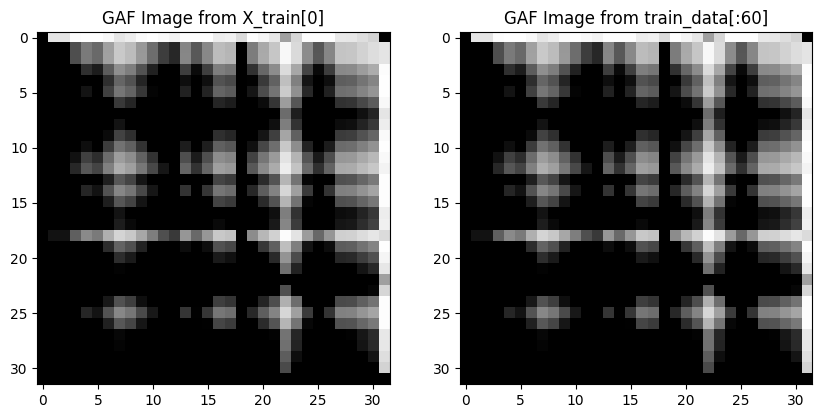

In [66]:
#Verification whether the plots are generated proper inside the loop
sequence_data = train_data[:SEQ_LEN]
sequence_data = sequence_data.reshape(1, -1)
gaf_transformed = gaf.transform(sequence_data)
resized_gaf = resize(gaf_transformed[0], (IMAGE_SIZE, IMAGE_SIZE))
resized_gaf_with_channel = np.expand_dims(resized_gaf, axis=-1)
expected_gaf_image = np.repeat(resized_gaf_with_channel, COLOR_CHANNELS, axis=-1)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_images[0])
axes[0].set_title('GAF Image from X_train[0]',fontsize=12)

axes[1].imshow(expected_gaf_image[:, :, :])
axes[1].set_title('GAF Image from train_data[:60]',fontsize=12)

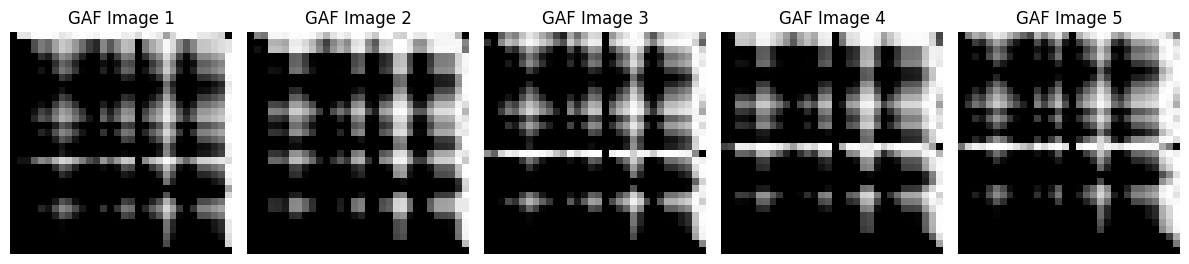

In [67]:
#Visualize the GAF-transformed images for train data
num_images_to_visualize = 5

fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(12, 4))
for i in range(num_images_to_visualize):
    axes[i].imshow(train_images[i], cmap='viridis')
    axes[i].set_title(f'GAF Image {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [68]:
#Conversion for test data
test_images = []
test_labels = []

for i in range(SEQ_LEN, len(test_data)):
    sequence_data = test_data[i - SEQ_LEN:i]
    sequence_data = sequence_data.reshape(1, -1)
    gaf_transformed = gaf.transform(sequence_data)
    resized_gaf = resize(gaf_transformed[0], (IMAGE_SIZE, IMAGE_SIZE))
    resized_gaf_with_channel = np.expand_dims(resized_gaf, axis=-1)
    gaf_image = np.repeat(resized_gaf_with_channel, COLOR_CHANNELS, axis=-1)
    test_images.append(gaf_image)
    test_labels.append(test_label[i + (FUTURE_PERIOD_PREDICT-1)])

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = np.array(test_labels).reshape(-1, 1)

In [69]:
#Verify shape of test labels and test images
print(test_images.shape)
print(test_labels.shape)

(63, 32, 32, 3)
(63, 1)


In [70]:
#Reshaping and casting the image data to a 4D tensor (samples, channels, height, width) as float32,
#then normalizing pixel values to the range [0, 1] by dividing by 255.0 for both training and testing images
train_images = tf.cast(train_images.reshape((-1, 3, 32, 32)),dtype=tf.float32)
test_images = tf.cast(test_images.reshape((-1, 3, 32, 32)),dtype=tf.float32)
train_images, test_images = train_images / 255.0, test_images / 255.0

In [71]:
#Verify the shape of images
train_images.shape

TensorShape([1053, 3, 32, 32])

In [72]:
#Creating train_x, train_y from the training images and labels respectively. Same is followed for Valid and Test data
train_x = tf.data.Dataset.from_tensor_slices(train_images,)
train_y = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_x,train_y))
test_x = tf.data.Dataset.from_tensor_slices(test_images)
test_y = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_x,test_y))

### **Vision Transformer**

In [73]:
#Gaussian Error Linear Unit
def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh(
        (math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf


#Maps a identifier to a Python function
def get_activation(identifier):
    if isinstance(identifier, six.string_types):
        name_to_fn = {"gelu": gelu}
        identifier = str(identifier).lower()
        if identifier in name_to_fn:
            return tf.keras.activations.get(name_to_fn[identifier])
    return tf.keras.activations.get(identifier)


class Residual(tf.keras.Model):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x


#Perform Prenormalization
class PreNorm(tf.keras.Model):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.fn = fn

    def call(self, x):
        return self.fn(self.norm(x))

#Define FeedForward Network
class FeedForward(tf.keras.Model):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation=get_activation('gelu')),
                                        tf.keras.layers.Dense(dim)])

    def call(self, x):
        return self.net(x)

#Define the Attention Layer Network
class Attention(tf.keras.Model):
    def __init__(self, dim, heads = 8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = tf.keras.layers.Dense(dim * 3, use_bias=False)
        self.to_out = tf.keras.layers.Dense(dim)

        self.rearrange_qkv = Rearrange('b n (qkv h d) -> qkv b h n d', qkv = 3, h = self.heads)
        self.rearrange_out = Rearrange('b h n d -> b n (h d)')

    def call(self, x):
        qkv = self.to_qkv(x)
        qkv = self.rearrange_qkv(qkv)
        q = qkv[0]
        k = qkv[1]
        v = qkv[2]

        dots = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = tf.nn.softmax(dots,axis=-1)

        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = self.rearrange_out(out)
        out =  self.to_out(out)
        return out

#Defining Transformer Architecture
class Transformer(tf.keras.Model):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ])
        self.net = tf.keras.Sequential(layers)

    def call(self, x):
        return self.net(x)

#Defining the Vision Transformer Architecture
class ViT(tf.keras.Model):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.dim = dim
        self.pos_embedding = self.add_weight("position_embeddings",
                                             shape=[num_patches + 1,
                                                    dim],
                                             initializer=tf.keras.initializers.RandomNormal(),
                                             dtype=tf.float32)
        self.patch_to_embedding = tf.keras.layers.Dense(dim)
        self.cls_token = self.add_weight("cls_token",
                                         shape=[1,
                                                1,
                                                dim],
                                         initializer=tf.keras.initializers.RandomNormal(),
                                         dtype=tf.float32)

        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)

        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = tf.identity

        self.mlp_head = tf.keras.Sequential([tf.keras.layers.Dense(mlp_dim, activation=get_activation('gelu')),
                                        tf.keras.layers.Dense(num_classes)])

    @tf.function
    def call(self, img):
        shapes = tf.shape(img)

        x = self.rearrange(img)
        x = self.patch_to_embedding(x)

        cls_tokens = tf.broadcast_to(self.cls_token,(shapes[0],1,self.dim))
        x = tf.concat((cls_tokens, x), axis=1)
        x += self.pos_embedding
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [74]:
#Create a logger with the name of the current module
logger = logging.getLogger(__name__)

#Define Parameters
class TrainerConfig:
    max_epochs = 50
    batch_size = 64
    learning_rate = 1e-6
    ckpt_path = None

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

In [75]:
#Define Trainer
class Trainer:
    def __init__(self, model, model_config, train_dataset, train_dataset_len, test_dataset, test_dataset_len, config):
        self.train_dataset = train_dataset.batch(config.batch_size)
        self.train_dataset_len = train_dataset_len
        self.test_dataset = test_dataset
        self.test_dataset_len = None
        self.test_dist_dataset = None
        if self.test_dataset:
            self.test_dataset = test_dataset.batch(config.batch_size)
            self.test_dataset_len = test_dataset_len
        self.config = config
        self.tokens = 0
        self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()

        with self.strategy.scope():
            self.model = model(**model_config)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
            self.cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            if self.test_dataset:
                self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def save_checkpoints(self):
        if self.config.ckpt_path is not None:
            self.model.save_weights(self.config.ckpt_path)


    def train(self):
        #Define the loss metric (Mean)
        train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
        test_loss_metric = tf.keras.metrics.Mean('testing_loss', dtype=tf.float32)

        #Define the accuracy metric
        train_accuracy = tf.keras.metrics.Accuracy('training_accuracy', dtype=tf.float32)
        test_accuracy = tf.keras.metrics.Accuracy('testing_accuracy', dtype=tf.float32)

        #Defining training step
        @tf.function
        def train_step(dist_inputs):
            def step_fn(inputs):

                X, Y = inputs

                with tf.GradientTape() as tape:
                    logits = self.model(X,training=True)
                    num_labels = tf.shape(logits)[-1]
                    label_mask = tf.math.logical_not(Y < 0)
                    label_mask = tf.reshape(label_mask,(-1,))
                    logits = tf.reshape(logits,(-1,num_labels))
                    logits_masked = tf.boolean_mask(logits,label_mask)
                    label_ids = tf.reshape(Y,(-1,))
                    label_ids_masked = tf.boolean_mask(label_ids,label_mask)
                    cross_entropy = self.cce(label_ids_masked, logits_masked)
                    loss = tf.reduce_sum(cross_entropy) * (1.0 / self.config.batch_size)
                    y_pred = tf.argmax(tf.nn.softmax(logits,axis=-1),axis=-1)
                    train_accuracy.update_state(tf.squeeze(Y),y_pred)

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(list(zip(grads, self.model.trainable_variables)))
                return cross_entropy

            per_example_losses = self.strategy.run(step_fn, args=(dist_inputs,))
            sum_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_example_losses, axis=0)
            mean_loss = sum_loss / self.config.batch_size
            return mean_loss

        #Defining Testing Step
        @tf.function
        def test_step(dist_inputs):

            def step_fn(inputs):

                X, Y = inputs
                logits = self.model(X,training=False)
                num_labels = tf.shape(logits)[-1]
                label_mask = tf.math.logical_not(Y < 0)
                label_mask = tf.reshape(label_mask,(-1,))
                logits = tf.reshape(logits,(-1,num_labels))
                logits_masked = tf.boolean_mask(logits,label_mask)
                label_ids = tf.reshape(Y,(-1,))
                label_ids_masked = tf.boolean_mask(label_ids,label_mask)
                cross_entropy = self.cce(label_ids_masked, logits_masked)
                loss = tf.reduce_sum(cross_entropy) * (1.0 / self.config.batch_size)
                y_pred = tf.argmax(tf.nn.softmax(logits,axis=-1),axis=-1)
                test_accuracy.update_state(tf.squeeze(Y),y_pred)
                return cross_entropy

            per_example_losses = self.strategy.run(step_fn, args=(dist_inputs,))
            sum_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_example_losses, axis=0)
            mean_loss = sum_loss / self.config.batch_size
            return mean_loss

        train_pb_max_len = math.ceil(float(self.train_dataset_len)/float(self.config.batch_size))
        test_pb_max_len = math.ceil(float(self.test_dataset_len)/float(self.config.batch_size)) if self.test_dataset else None

        epoch_bar = master_bar(range(self.config.max_epochs))
        with self.strategy.scope():
            for epoch in epoch_bar:
                for inputs in progress_bar(self.train_dist_dataset,total=train_pb_max_len,parent=epoch_bar):
                    loss = train_step(inputs)
                    self.tokens += tf.reduce_sum(tf.cast(inputs[1]>=0,tf.int32)).numpy()
                    train_loss_metric(loss)
                    epoch_bar.child.comment = f'training loss : {train_loss_metric.result()}'
                print(f"epoch {epoch+1}: train loss {train_loss_metric.result():.5f}. train accuracy {train_accuracy.result():.5f}")
                train_loss_metric.reset_states()
                train_accuracy.reset_states()

                if self.test_dist_dataset:
                    for inputs in progress_bar(self.test_dist_dataset,total=test_pb_max_len,parent=epoch_bar):
                        loss = test_step(inputs)
                        test_loss_metric(loss)
                        epoch_bar.child.comment = f'testing loss : {test_loss_metric.result()}'
                    print(f"epoch {epoch+1}: test loss {test_loss_metric.result():.5f}. test accuracy {test_accuracy.result():.5f}")
                    test_loss_metric.reset_states()
                    test_accuracy.reset_states()

                self.save_checkpoints()

In [76]:
# Create an instance of the TrainerConfig class with customized parameters
tconf = TrainerConfig(max_epochs=50, batch_size=64, learning_rate=1e-6)

#### **Training and Testing the Model**

In [77]:
#Model Configuration
model_config = {"image_size":32,
                "patch_size":4,
                "num_classes":2,
                "dim":128,
                "depth":4,
                "heads":4,
                "mlp_dim":128}

In [78]:
# Instantiate a Trainer object for a Vision Transformer (ViT) model with specified configurations and datasets
trainer = Trainer(ViT, model_config, train_dataset, len(train_images), test_dataset, len(test_images), tconf)

In [37]:
#Model Training
trainer.train()

epoch 1: train loss 0.68354. train accuracy 0.47293
epoch 1: test loss 0.68834. test accuracy 0.47619
epoch 2: train loss 0.68027. train accuracy 0.48528
epoch 2: test loss 0.68553. test accuracy 0.46032
epoch 3: train loss 0.67798. train accuracy 0.48813
epoch 3: test loss 0.68383. test accuracy 0.50794
epoch 4: train loss 0.67621. train accuracy 0.48718
epoch 4: test loss 0.68234. test accuracy 0.46032
epoch 5: train loss 0.67487. train accuracy 0.49193
epoch 5: test loss 0.68113. test accuracy 0.50794
epoch 6: train loss 0.67385. train accuracy 0.49098
epoch 6: test loss 0.68023. test accuracy 0.52381
epoch 7: train loss 0.67307. train accuracy 0.50237
epoch 7: test loss 0.67951. test accuracy 0.52381
epoch 8: train loss 0.67247. train accuracy 0.49953
epoch 8: test loss 0.67892. test accuracy 0.52381
epoch 9: train loss 0.67200. train accuracy 0.49858
epoch 9: test loss 0.67846. test accuracy 0.53968
epoch 10: train loss 0.67162. train accuracy 0.49953
epoch 10: test loss 0.67809. 